In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Database overview

In [15]:
from pathlib import Path

# Path to the original folder
root_dir = Path("/content/drive/MyDrive/ProyectoDIP/Kindey Stone Dataset/Original")

# Valid image extensions
image_extensions = {".jpg", ".jpeg", ".png"}

# Count all images (including subfolders)
total_images = sum(1 for f in root_dir.rglob("*") if f.suffix.lower() in image_extensions)

print(f"Total images in the 'Original' folder: {total_images}")


Total images in the 'Original' folder: 3364


In [ ]:
import os
import shutil
import random
import pandas as pd
from pathlib import Path
import tensorflow as tf

#It is only necessary to perform the database split
# Root path with the original images
root_dir = Path("/content/drive/My Drive/ProyectoDIP/Kindey Stone Dataset/Original")

# Valid image extensions
image_extensions = {".jpg", ".jpeg", ".png"}

# New folder for the split data
output_base = root_dir.parent / "CT"
train_dir = output_base / "train"
val_dir = output_base / "val"

# Create destination folders
for class_name in ["Stone", "Non-Stone"]:
    (train_dir / class_name).mkdir(parents=True, exist_ok=True)
    (val_dir / class_name).mkdir(parents=True, exist_ok=True)

# Counter for summary
summary = {"Set": [], "Class": [], "Count": []}

# Set seed for reproducibility
random.seed(42)

# Iterate over classes
for class_name in ["Stone", "Non-Stone"]:
    class_path = root_dir / class_name
    images = [f for f in class_path.iterdir() if f.suffix.lower() in image_extensions]

    random.shuffle(images)
    split_idx = int(0.7 * len(images))
    train_images = images[:split_idx]
    val_images = images[split_idx:]

    # Copy images
    for img_path in train_images:
        shutil.copy(img_path, train_dir / class_name)
    for img_path in val_images:
        shutil.copy(img_path, val_dir / class_name)

    # Summary
    summary["Set"].append("train")
    summary["Class"].append(class_name)
    summary["Count"].append(len(train_images))

    summary["Set"].append("val")
    summary["Class"].append(class_name)
    summary["Count"].append(len(val_images))

# Display summary as DataFrame
df_summary = pd.DataFrame(summary)
print(df_summary)


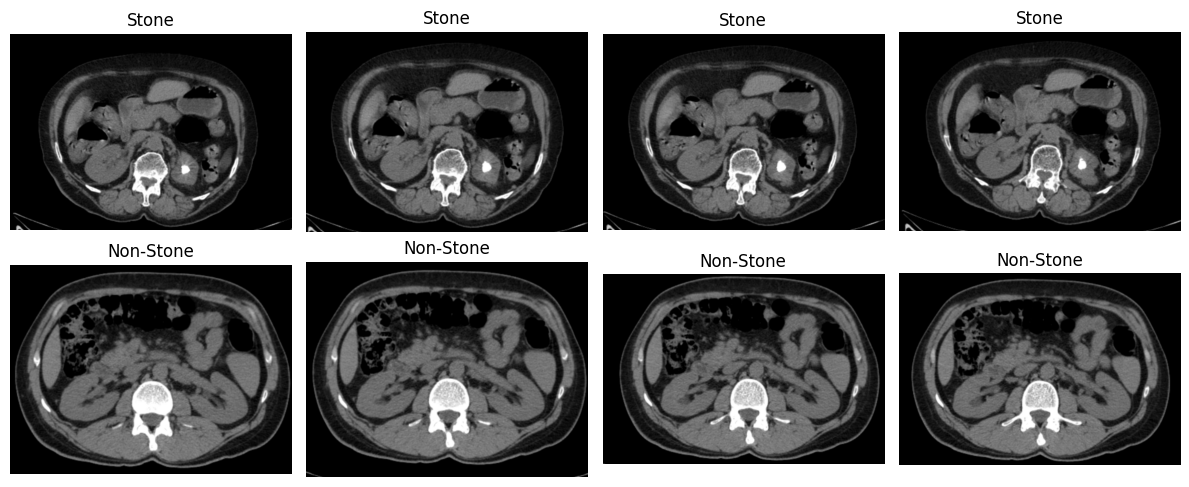

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from pathlib import Path

# Root path
train_path = Path("/content/drive/My Drive/ProyectoDIP/Kindey Stone Dataset/CT/train")
val_path = Path("/content/drive/My Drive/ProyectoDIP/Kindey Stone Dataset/CT/val")

# Classes to display
classes = ["Stone", "Non-Stone"]

# Lists to store images and labels
selected_imgs = []
selected_labels = []

# Figure size
plt.figure(figsize=(12, 5))

img_index = 1

for class_name in classes:
    class_path = os.path.join(train_path, class_name)
    images = [f for f in os.listdir(class_path) if os.path.splitext(f)[1].lower() in [".jpg", ".jpeg", ".png"]]

    # Select images
    selected_images = sorted(images)[1099:1103]
    # selected_images = sorted(images)

    for img_file in selected_images:
        img_path = os.path.join(class_path, img_file)
        img = mpimg.imread(img_path)

        # Store image and label
        selected_imgs.append(img)
        selected_labels.append(class_name)

        # Display image
        plt.subplot(2, 4, img_index)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

        img_index += 1

plt.tight_layout()
plt.show()


# PREPROCESSING

In [ ]:
import numpy as np
from PIL import Image
import os
from pathlib import Path
from scipy.ndimage import median_filter
from skimage.filters import sobel
import random
import tensorflow as tf

def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Set seed for reproducibility
random.seed(42)

# Preprocessing functions
def normalize(img):
    return img.astype(np.float32) / 255.0

def median_filter_img(img, size=3):
    return median_filter(img, size=size)

def mask_edges_column(img, threshold=0.12):
    edges = sobel(img)
    edges_mask = edges > threshold
    img_masked = img.copy()
    img_masked[edges_mask] = 0.0
    return img_masked

def gamma_correction(img, gamma=2.0):
    return np.power(img, gamma)

def resize_image(img, size=(512, 512)):
    return np.array(img.resize(size))

def preprocess(img):
    img = resize_image(img)
    img = normalize(img)
    img = median_filter_img(img)
    img = mask_edges_column(img)
    img = gamma_correction(img, gamma=2)
    return img

# Function to process all images in a directory
def process_directory(base_path):
    base_path = Path(base_path)
    classes = ["Stone", "Non-Stone"]

    processed_images = []
    labels = []

    for class_name in classes:
        class_path = base_path / class_name
        for file in os.listdir(class_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    img_path = class_path / file
                    img = Image.open(img_path).convert("L")
                    img_proc = preprocess(img)

                    processed_images.append(img_proc)
                    labels.append(class_name)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

    return np.array(processed_images), np.array(labels)

# Process training and validation sets
train_path = "/content/drive/My Drive/ProyectoDIP/Kindey Stone Dataset/CT/train"
val_path = "/content/drive/My Drive/ProyectoDIP/Kindey Stone Dataset/CT/val"

X_train, y_train = process_directory(train_path)
X_val, y_val = process_directory(val_path)

print(f"Train: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation: {X_val.shape}, Labels: {y_val.shape}")

Train: (2353, 512, 512), Labels: (2353,)
Val: (1011, 512, 512), Labels: (1011,)


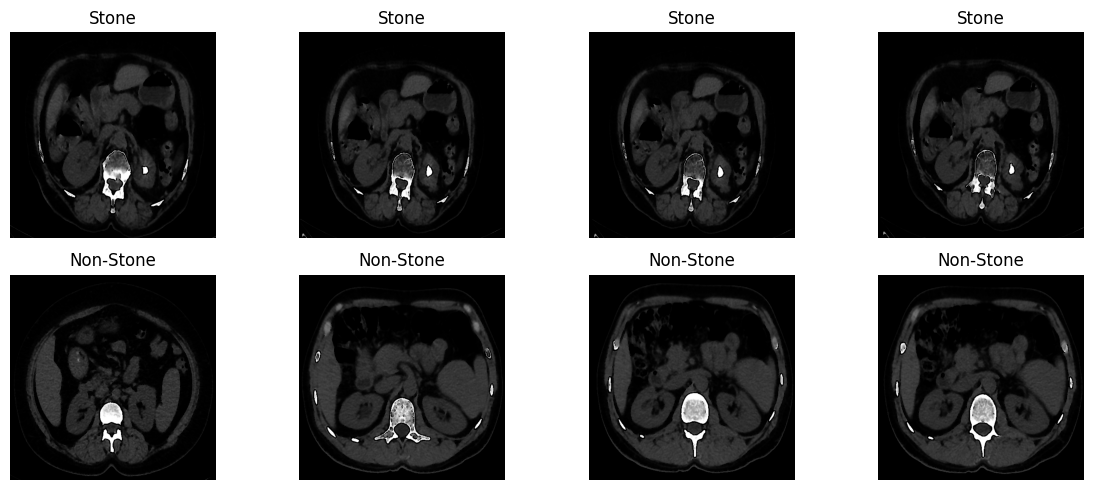

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os

# Root path
train_path = Path("/content/drive/My Drive/ProyectoDIP/Kindey Stone Dataset/CT/train")
clases = ["Stone", "Non-Stone"]

selected_filenames = []

for clase in clases:
    class_path = train_path / clase
    all_images = sorted([f for f in os.listdir(class_path) if os.path.splitext(f)[1].lower() in [".jpg", ".jpeg", ".png"]])
    selected_filenames += [(clase, fname) for fname in all_images[1099:1103]]


plt.figure(figsize=(12, 7))
img_index = 1

for clase, filename in selected_filenames:

    full_path = train_path / clase / filename

    img = Image.open(full_path).convert("L")
    img_proc = preprocess(img)

    plt.subplot(2, 4, img_index)
    plt.imshow(img_proc, cmap='gray')
    plt.title(f"{clase}")
    plt.axis('off')
    img_index += 1

plt.tight_layout()
plt.show()


# CNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

X_train_cnn = np.expand_dims(X_train, axis=-1)
X_val_cnn = np.expand_dims(X_val, axis=-1)

# Convert labels to 0 and 1
y_train_bin = np.array([1 if label == 'Stone' else 0 for label in y_train])
y_val_bin = np.array([1 if label == 'Stone' else 0 for label in y_val])

# CNN Model
modelCNN = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.0001), input_shape=(512, 512, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.4),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])


modelCNN.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(modelCNN.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 510, 510, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   251,920,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,014,081 (961.36 MB)

 Trainable params: 252,014,081 (961.36 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:

history = modelCNN.fit(
    X_train_cnn, y_train_bin,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_cnn, y_val_bin)
)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 65s 610ms/step - accuracy: 0.6973 - loss: 0.5545 - val_accuracy: 0.9120 - val_loss: 0.2192
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 289ms/step - accuracy: 0.9582 - loss: 0.1145 - val_accuracy: 0.9149 - val_loss: 0.2250
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 296ms/step - accuracy: 0.9731 - loss: 0.0780 - val_accuracy: 0.9327 - val_loss: 0.2105
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 295ms/step - accuracy: 0.9930 - loss: 0.0308 - val_accuracy: 0.9347 - val_loss: 0.1793
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 40s 289ms/step - accuracy: 0.9951 - loss: 0.0317 - val_accuracy: 0.9308 - val_loss: 0.2656
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 291ms/step - accuracy: 0.9937 - loss: 0.0352 - val_accuracy: 0.9416 - val_loss: 0.1915
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 296ms/step - accuracy: 0.9944 - loss: 0.0226 - val_accuracy: 0.9407 - val_loss: 0.1734
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 296ms/step - accuracy: 0.9950 - loss: 0.0347 - val_accu

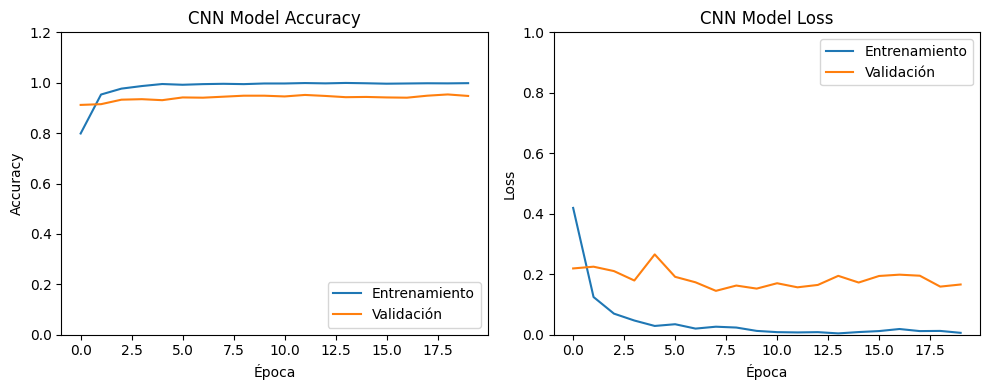

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('CNN Model Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.ylim([0, 1.2])
plt.legend(loc='lower right')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('CNN Model Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')


plt.tight_layout()
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


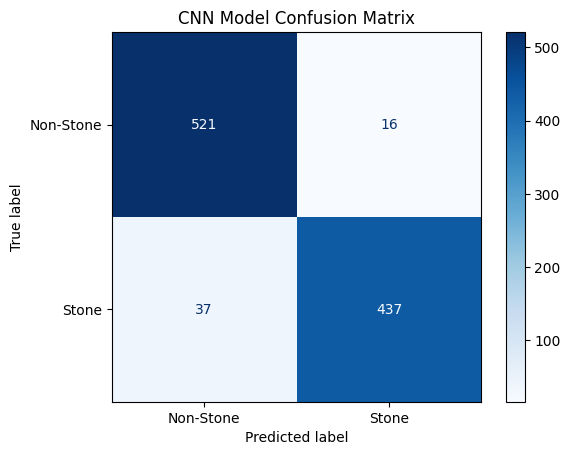

╒═══════════╤═════════╕
│ Metric    │   Value │
╞═══════════╪═════════╡
│ Accuracy  │  0.9476 │
├───────────┼─────────┤
│ Precision │  0.9647 │
├───────────┼─────────┤
│ Recall    │  0.9219 │
├───────────┼─────────┤
│ F1-Score  │  0.9428 │
├───────────┼─────────┤
│ AUC       │  0.9895 │
╘═══════════╧═════════╛


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

y_pred_probs = modelCNN.predict(X_val_cnn)

# Convert probabilities to binary labels
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# Generate confusion matrix
cm = confusion_matrix(y_val_bin, y_pred)
labels = ['Non-Stone', 'Stone']  # 0 = Non-Stone, 1 = Stone

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("CNN Model Confusion Matrix")
plt.show()

# Calculate evaluation metrics
accuracy = accuracy_score(y_val_bin, y_pred)
precision = precision_score(y_val_bin, y_pred)
recall = recall_score(y_val_bin, y_pred)
f1 = f1_score(y_val_bin, y_pred)
auc = roc_auc_score(y_val_bin, y_pred_probs)

# Create a table with pandas
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'],
    'Value': [accuracy, precision, recall, f1, auc]
})

# Format values to 4 decimal places
metrics_df['Value'] = metrics_df['Value'].apply(lambda x: f"{x:.4f}")


# Display table nicely with tabulate
print(tabulate(metrics_df, headers='keys', tablefmt='fancy_grid', showindex=False))
